# Doc2Vec EDA
This file explores the use of Doc2Vec to generate 100-dimension vectors per movie, based on the description text previously fetched from TMDb API.
We compare (visually) the clustering of different genres - e.g. can we see movies with similar broad themes (Sci-fi, Western ...) sitting near one another in vector space? To do this, we use TSNE - a feature-reduction approach which aims to retain the majority of variance displayed across all input features and records.
Finally, we compare the outcome when we include a list of genres at the end of the text description - does including this further improve spatial clustering?

In [6]:
import pandas as pd
import numpy as np
import os
import json

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from gensim.parsing.preprocessing import STOPWORDS 
from gensim.utils import simple_preprocess

from nltk.stem.lancaster import LancasterStemmer

# define function to perform one-hot encoding (a column flag for each genre) and pivot data
def create_genre_flags(df, col_list, id_vars=['movieID']):
    print('Encoding the following genres: '+', '.join(col_list))
    output=df.copy()
    for each in col_list:
        output[each]=output.genres_raw.apply(lambda x: 1 if each in x else 0)
    return output

def preprocessor_and_stem(text, my_stop_words):
    """uses gensim simple_preprocess and then removes stop words
    -> used in the tag_docs function
    """
    # Instantiate a LancasterStemmer object, use gensim simple_preprocess to tokenize/lowercase
    # and then removes stop words
    ls = LancasterStemmer()
    simple = simple_preprocess(text)
    result = [ls.stem(word) for word in simple if not word in my_stop_words]
    return result

def stem_tag_docs(docs, my_stop_words, id_col='id', text_col='text'):
    results = docs.apply(lambda r: TaggedDocument(words=preprocessor_and_stem(r[text_col], my_stop_words), tags=[str(r[id_col])]), axis=1)
    return results.tolist()

def categorise_attribute(variable, genres):
    if variable in ['tsne_x', 'tsne_y']:
        return 'tsne_doc2vec'
    elif variable in genres:
        return 'genre'
    elif isinstance(variable, str):
        return 'other'
    elif isinstance(variable, int):
        return 'doc2vec'


my_stop_words = STOPWORDS

In [2]:
#Load in configs and dependencies

baseDir=os.getcwd()
parentDir=os.path.dirname(baseDir)
configLocation=os.path.join(baseDir, "config.json")
with open(configLocation, "r") as f:
    configs = json.load(f)

datafolder=os.path.join(parentDir,configs["inputfolder"])
outputfolder=os.path.join(parentDir,configs["outputfolder"])
tempfolder = os.path.join(parentDir,configs["tempfolder"])


Let's compare how well the movie genres cluster based on the Doc2Vec of their descriptions either with or without the genre list concatenated...

### Without genres within text

In [3]:
movieData=pd.read_csv(f'{tempfolder}/movie_fact.csv',usecols=['movieID', 'description', 'genres_raw', 'release_year'])
movieData.description=movieData.description.astype(str)
movieData['description_genre']=movieData.description+' '+movieData.genres_raw
movieData.description_genre=movieData.description_genre.astype(str)

# create one-hot flag per genre and pivot the data (wide to long)
genres=list(set(np.concatenate(movieData.genres_raw.str.split(', '))))
movieData=create_genre_flags(movieData, genres)

movieData.info()

Encoding the following genres: Drama, Action, War, Fantasy, Children, Thriller, Documentary, Musical, Horror, IMAX, Film-Noir, Romance, (no genres listed), Western, Crime, Mystery, Sci-Fi, Adventure, Animation, Comedy
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   release_year        9742 non-null   int64 
 1   genres_raw          9742 non-null   object
 2   description         9742 non-null   object
 3   movieID             9742 non-null   object
 4   description_genre   9742 non-null   object
 5   Drama               9742 non-null   int64 
 6   Action              9742 non-null   int64 
 7   War                 9742 non-null   int64 
 8   Fantasy             9742 non-null   int64 
 9   Children            9742 non-null   int64 
 10  Thriller            9742 non-null   int64 
 11  Documentary         9742 non-null   int64 
 12

In [56]:
# filter out any cases where descirption is null before doing stemming
tagged_stem_docs = stem_tag_docs(movieData[movieData.description!='nan'][['movieID', 'description']], my_stop_words,  id_col='movieID', text_col='description')
# Instantiate a Doc2Vec model, and build the vocab from the tagged documents
model = Doc2Vec(dm=0, dbow_words=1, min_count=4)

model.build_vocab(tagged_stem_docs, progress_per = 100)
model.train(tagged_stem_docs, total_examples=model.corpus_count, epochs=10)

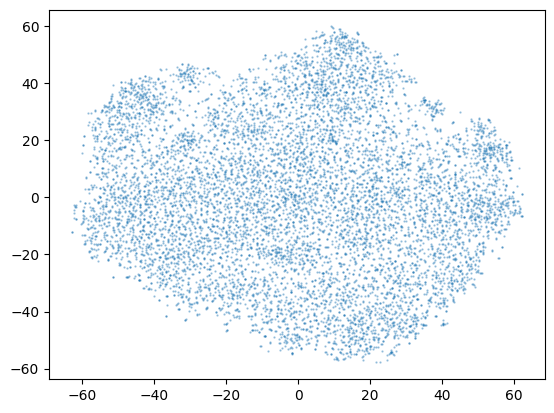

In [57]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
doc_tags = list(model.dv.key_to_index.keys())
X = model[doc_tags]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
df = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y']).reset_index()
plt.scatter(df['x'], df['y'], s=0.4, alpha=0.4)

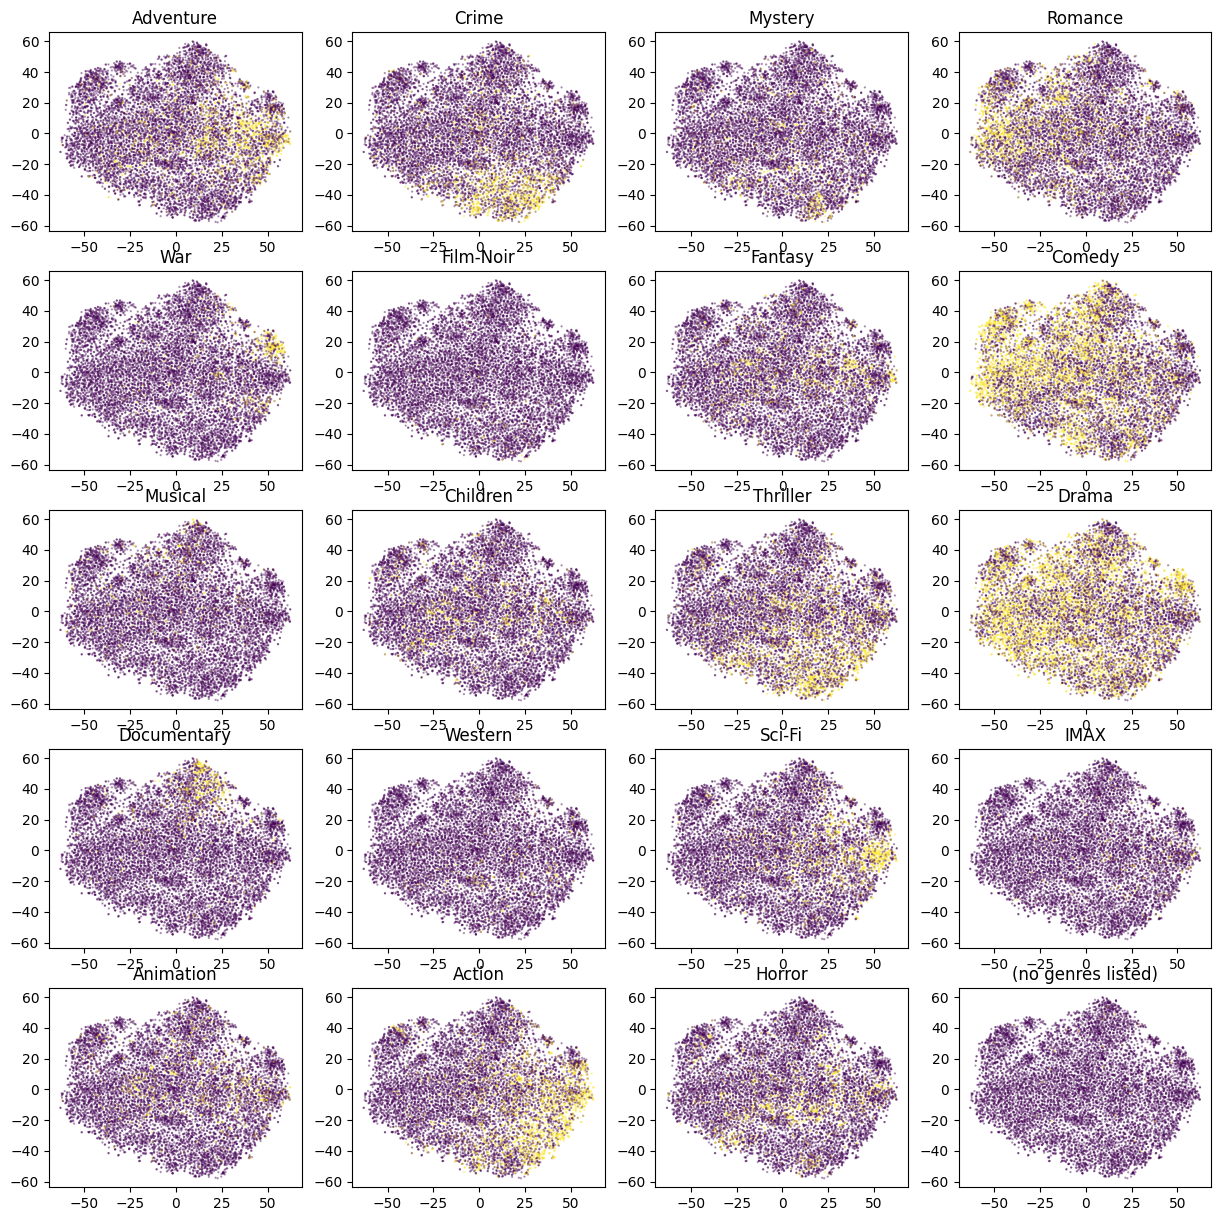

In [59]:
fig, ax=plt.subplots(5, 4, figsize=(15, 15))
row=0
col=0

for i in range(len(genres)):
    genre=genres[i]

    ax[row,col].scatter(df['x'], df['y'], c=movieData[movieData.description!='nan'][genre], s=0.4, alpha=0.4)
    ax[row,col].set_title(genre)
    i+=1
    
    if i%4==0:
        row+=1
    col=i%4


### With Genre labels in text

In [40]:

tagged_stem_docs_genre = stem_tag_docs(movieData[['movieID', 'description_genre']], my_stop_words, id_col='movieID', text_col='description_genre')
# Instantiate a Doc2Vec model, and build the vocab from the tagged documents
model_genre = Doc2Vec(dm=0, dbow_words=1, min_count=4)

model_genre.build_vocab(tagged_stem_docs_genre, progress_per = 100)
model_genre.train(tagged_stem_docs_genre, total_examples=model_genre.corpus_count, epochs=10)

In [41]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
doc_tags = list(model_genre.dv.key_to_index.keys())
X_genre = model_genre[doc_tags]
tsne_genre = TSNE(n_components=2)
X_tsne_genre = tsne_genre.fit_transform(X_genre)
df_genre = pd.DataFrame(X_tsne_genre, index=doc_tags,columns=['tsne_x', 'tsne_y']).reset_index()
plt.scatter(df_genre['tsne_x'], df_genre['tsne_y'], s=0.4, alpha=0.4)

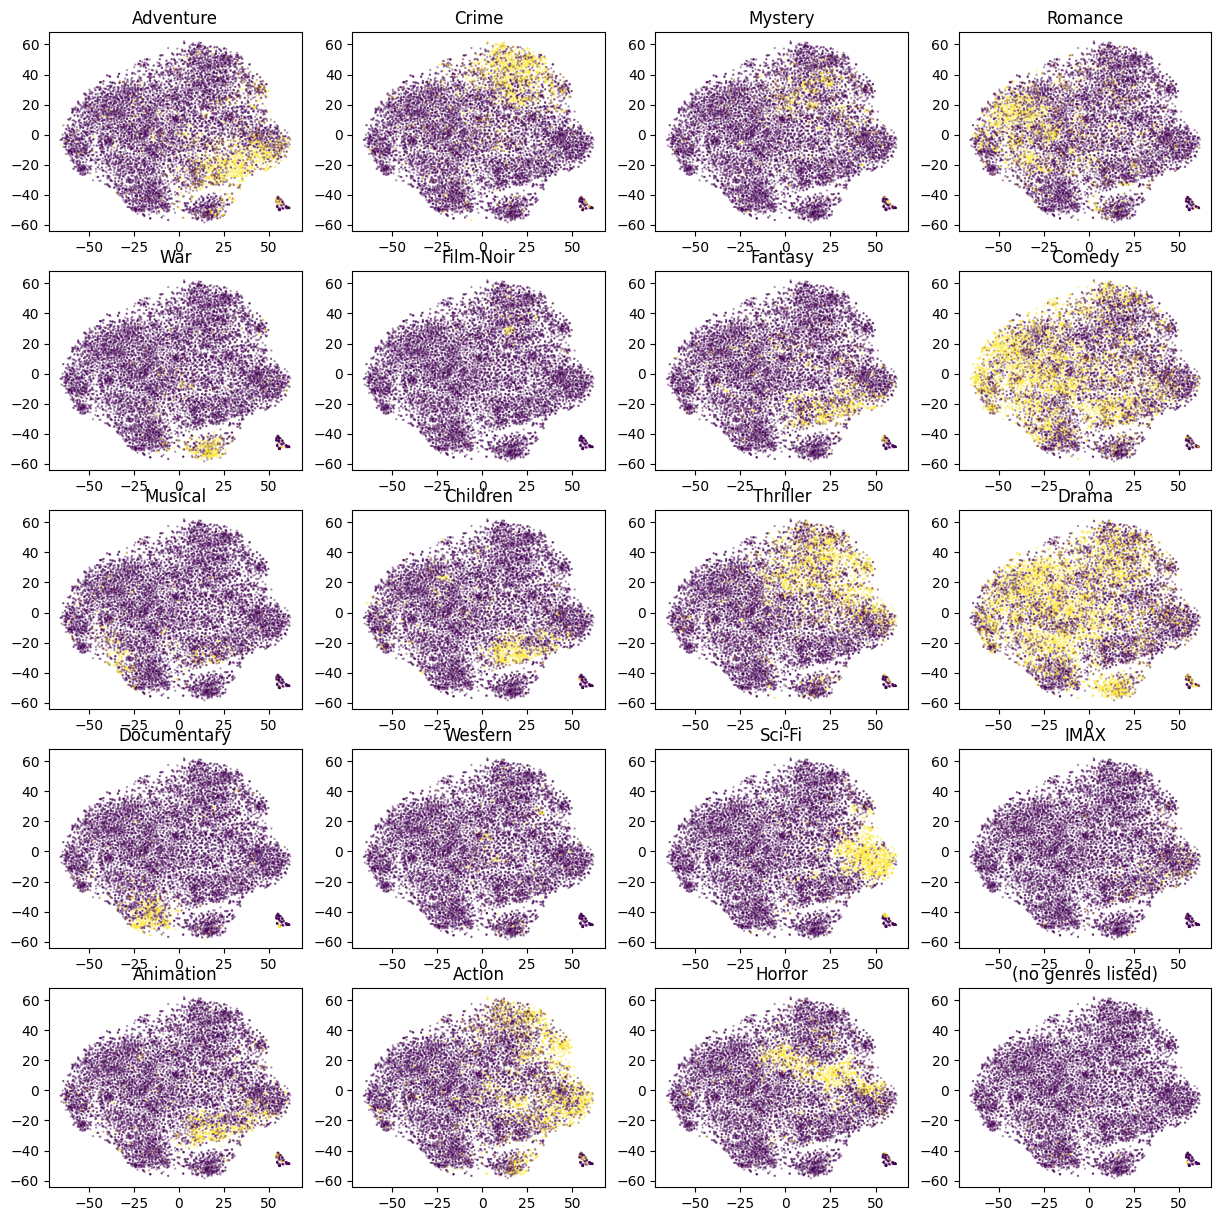

In [42]:
fig, ax=plt.subplots(5, 4, figsize=(15, 15))
row=0
col=0

for i in range(len(genres)):
    genre=genres[i]

    ax[row,col].scatter(df_genre['tsne_x'], df_genre['tsne_y'], c=movieData[genre], s=0.4, alpha=0.4)
    ax[row,col].set_title(genre)
    i+=1
    
    if i%4==0:
        row+=1
    col=i%4
